In [66]:
# 모듈 불러오기
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
# 경로 설정
root_path = '/content/drive/My Drive/TOY/DACON/DACON-JEJU'
data_path = os.path.join(root_path, 'data')
submission_path = os.path.join(root_path, 'submission')

# _1_. 곱연산 템플릿

- 데이터 : 내가 year, month 추가해 놓은 raw로 불러 오기
- 결측치 있는 피쳐는 날리기

In [3]:
# 데이터 로드
df_raw = pd.read_csv(f"{data_path}/201901-202003.csv")

In [4]:
# 결측치 열 확인 및 제거
df_raw.isnull().sum()
df_raw = df_raw.drop(columns=['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1)
df_raw

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,건강보조식품 소매업,강원,20s,1,1,4,311200,4
1,201901,강원,건강보조식품 소매업,강원,30s,1,2,7,1374500,8
2,201901,강원,건강보조식품 소매업,강원,30s,2,2,6,818700,6
3,201901,강원,건강보조식품 소매업,강원,40s,1,3,4,1717000,5
4,201901,강원,건강보조식품 소매업,강원,40s,1,4,3,1047300,3
...,...,...,...,...,...,...,...,...,...,...
24697787,202003,충북,휴양콘도 운영업,충북,30s,1,2,3,43300,4
24697788,202003,충북,휴양콘도 운영업,충북,40s,1,3,3,35000,3
24697789,202003,충북,휴양콘도 운영업,충북,50s,1,4,4,188000,6
24697790,202003,충북,휴양콘도 운영업,충북,50s,2,4,4,99000,6


In [8]:
# 날짜 조합: 201901~202003
df_raw.groupby(by=['REG_YYMM']).count()

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
REG_YYMM,,,,,,,,,
201901,1607032,1607032,1607032,1607032,1607032,1607032,1607032,1607032,1607032
201902,1594266,1594266,1594266,1594266,1594266,1594266,1594266,1594266,1594266
201903,1668675,1668675,1668675,1668675,1668675,1668675,1668675,1668675,1668675
201904,1655655,1655655,1655655,1655655,1655655,1655655,1655655,1655655,1655655
201905,1772237,1772237,1772237,1772237,1772237,1772237,1772237,1772237,1772237
201906,1712696,1712696,1712696,1712696,1712696,1712696,1712696,1712696,1712696
201907,1721353,1721353,1721353,1721353,1721353,1721353,1721353,1721353,1721353
201908,1880296,1880296,1880296,1880296,1880296,1880296,1880296,1880296,1880296
201909,1734914,1734914,1734914,1734914,1734914,1734914,1734914,1734914,1734914


## 사용할 컬럼

columns = ['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC']

## +) merge해야 할 원본 데이터 저장

In [11]:
columns = ['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC']
df = df_raw.groupby(columns).sum().reset_index(drop=False)

In [12]:
df

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,건강보조식품 소매업,강원,20s,1,1,4,311200,4
1,201901,강원,건강보조식품 소매업,강원,30s,1,2,44,5169295,45
2,201901,강원,건강보조식품 소매업,강원,30s,2,2,89,8618550,91
3,201901,강원,건강보조식품 소매업,강원,40s,1,2,3,454420,3
4,201901,강원,건강보조식품 소매업,강원,40s,1,3,53,6441165,60
...,...,...,...,...,...,...,...,...,...,...
1057389,202003,충북,휴양콘도 운영업,충북,40s,1,4,9,385700,10
1057390,202003,충북,휴양콘도 운영업,충북,50s,1,4,10,790350,19
1057391,202003,충북,휴양콘도 운영업,충북,50s,2,4,4,99000,6
1057392,202003,충북,휴양콘도 운영업,충북,60s,1,5,6,228800,6


In [13]:
df.to_csv(f"{data_path}/jeju-raw-202003.csv", index=False, encoding='utf-8-sig')

## +) 템플릿 만들기

- year, month 제외 : `17 * 41 * 17 * 7 * 2 * 5` = 829430
- 그냥 내가 만든 템플릿 방식대로 하면
    - 201901~202012 : 19906320!
    - drop : 2020이면서 month가 4 ~ 12면 drop
- year, month까지 가면 
    - 201901 ~ 202003 : 15개
    - `15 * 829430` = 12441450



In [11]:
# feature별 unique값 확인
columns = ['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC']

for column in columns:
    print(f"================== {column} ==================")
    print(f"    총 unique feature: {df_raw[column].nunique()}")
    print(df_raw[column].unique())
    print()

================== REG_YYMM ==================
    총 unique feature: 15
[201901 201902 201903 201904 201905 201906 201907 201908 201909 201910
 201911 201912 202001 202002 202003]

================== CARD_SIDO_NM ==================
    총 unique feature: 17
['강원' '경기' '경남' '경북' '광주' '대구' '대전' '부산' '서울' '세종' '울산' '인천' '전남' '전북'
 '제주' '충남' '충북']

================== STD_CLSS_NM ==================
    총 unique feature: 41
['건강보조식품 소매업' '골프장 운영업' '과실 및 채소 소매업' '관광 민예품 및 선물용품 소매업'
 '그외 기타 스포츠시설 운영업' '그외 기타 종합 소매업' '기타 대형 종합 소매업' '기타 외국식 음식점업' '기타 주점업'
 '기타음식료품위주종합소매업' '마사지업' '비알콜 음료점업' '빵 및 과자류 소매업' '서양식 음식점업' '수산물 소매업'
 '슈퍼마켓' '스포츠 및 레크레이션 용품 임대업' '여관업' '욕탕업' '육류 소매업' '일반유흥 주점업' '일식 음식점업'
 '전시 및 행사 대행업' '중식 음식점업' '차량용 가스 충전업' '차량용 주유소 운영업' '체인화 편의점'
 '피자 햄버거 샌드위치 및 유사 음식점업' '한식 음식점업' '호텔업' '화장품 및 방향제 소매업' '휴양콘도 운영업' '여행사업'
 '자동차 임대업' '면세점' '버스 운송업' '택시 운송업' '기타 수상오락 서비스업' '내항 여객 운송업'
 '그외 기타 분류안된 오락관련 서비스업' '정기 항공 운송업']

================== HOM_SIDO_NM ==================
    총 unique feature:

In [13]:
# 곱 연산 통해 모든 경우의 수 만들기
REG_YYMMs = df['REG_YYMM'].unique()
CARD_SIDO_NMs = df['CARD_SIDO_NM'].unique()
STD_CLSS_NMs = df['STD_CLSS_NM'].unique()
HOM_SIDO_NMs = df['HOM_SIDO_NM'].unique()
AGEs = df['AGE'].unique()
SEX_CTGO_CDs = df['SEX_CTGO_CD'].unique()
FLCs = df['FLC'].unique()

temp = []
for REG_YYMM in REG_YYMMs:
    for CARD_SIDO_NM in CARD_SIDO_NMs:
        for STD_CLSS_NM in STD_CLSS_NMs:
            for HOM_SIDO_NM in HOM_SIDO_NMs:
                for AGE in AGEs:
                    for SEX_CTGO_CD in SEX_CTGO_CDs:
                        for FLC in FLCs:
                            temp.append([REG_YYMM, CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC])

temp = np.array(temp)
df_temp = pd.DataFrame(data=temp, columns=columns)
display(df_temp)                   

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC
0,201901,강원,건강보조식품 소매업,강원,20s,1,1
1,201901,강원,건강보조식품 소매업,강원,20s,1,2
2,201901,강원,건강보조식품 소매업,강원,20s,1,3
3,201901,강원,건강보조식품 소매업,강원,20s,1,4
4,201901,강원,건강보조식품 소매업,강원,20s,1,5
...,...,...,...,...,...,...,...
12441445,202003,충북,정기 항공 운송업,제주,10s,2,1
12441446,202003,충북,정기 항공 운송업,제주,10s,2,2
12441447,202003,충북,정기 항공 운송업,제주,10s,2,3
12441448,202003,충북,정기 항공 운송업,제주,10s,2,4


In [ ]:
df_temp.to_csv(f"{data_path}/jeju-template-all.csv", index=False, encoding='utf-8-sig')

## ========== 아래는 필요 없는 것들 =========

### +) 템플릿에서 202004 이후 날리기

In [3]:
df_temp = pd.read_csv(f"{data_path}/jeju-template-all.csv")

In [8]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19906320 entries, 0 to 19906319
Data columns (total 8 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   year          int64 
 1   month         int64 
 2   CARD_SIDO_NM  object
 3   STD_CLSS_NM   object
 4   HOM_SIDO_NM   object
 5   AGE           object
 6   SEX_CTGO_CD   int64 
 7   FLC           int64 
dtypes: int64(4), object(4)
memory usage: 1.2+ GB


In [9]:
df_temp['YYMM'] = df_temp['year']*100 + df_temp['month']
df_temp

,year,month,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,YYMM
0,2019,1,강원,건강보조식품 소매업,강원,20s,1,1,201901
1,2019,1,강원,건강보조식품 소매업,강원,20s,1,2,201901
2,2019,1,강원,건강보조식품 소매업,강원,20s,1,3,201901
3,2019,1,강원,건강보조식품 소매업,강원,20s,1,4,201901
4,2019,1,강원,건강보조식품 소매업,강원,20s,1,5,201901
...,...,...,...,...,...,...,...,...,...
19906315,2020,12,충북,정기 항공 운송업,제주,10s,2,1,202012
19906316,2020,12,충북,정기 항공 운송업,제주,10s,2,2,202012
19906317,2020,12,충북,정기 항공 운송업,제주,10s,2,3,202012
19906318,2020,12,충북,정기 항공 운송업,제주,10s,2,4,202012


In [11]:
df = df_temp.loc[df_temp['YYMM'] <= 202003]
df

,year,month,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,YYMM
0,2019,1,강원,건강보조식품 소매업,강원,20s,1,1,201901
1,2019,1,강원,건강보조식품 소매업,강원,20s,1,2,201901
2,2019,1,강원,건강보조식품 소매업,강원,20s,1,3,201901
3,2019,1,강원,건강보조식품 소매업,강원,20s,1,4,201901
4,2019,1,강원,건강보조식품 소매업,강원,20s,1,5,201901
...,...,...,...,...,...,...,...,...,...
12441445,2020,3,충북,정기 항공 운송업,제주,10s,2,1,202003
12441446,2020,3,충북,정기 항공 운송업,제주,10s,2,2,202003
12441447,2020,3,충북,정기 항공 운송업,제주,10s,2,3,202003
12441448,2020,3,충북,정기 항공 운송업,제주,10s,2,4,202003


In [12]:
df.drop('YYMM', axis=1, inplace=True)
df.to_csv(f"{data_path}/jeju_template_201901-202003.csv", index=False, encoding='utf-8-sig')

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### +) AMT 열 추가

In [3]:
df_temp = pd.read_csv(f"{data_path}/jeju_template_201901-202003.csv")
df_temp['AMT'] = ''
df_temp

,year,month,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT
0,2019,1,강원,건강보조식품 소매업,강원,20s,1,1,
1,2019,1,강원,건강보조식품 소매업,강원,20s,1,2,
2,2019,1,강원,건강보조식품 소매업,강원,20s,1,3,
3,2019,1,강원,건강보조식품 소매업,강원,20s,1,4,
4,2019,1,강원,건강보조식품 소매업,강원,20s,1,5,
...,...,...,...,...,...,...,...,...,...
12441445,2020,3,충북,정기 항공 운송업,제주,10s,2,1,
12441446,2020,3,충북,정기 항공 운송업,제주,10s,2,2,
12441447,2020,3,충북,정기 항공 운송업,제주,10s,2,3,
12441448,2020,3,충북,정기 항공 운송업,제주,10s,2,4,


In [4]:
df_temp.to_csv(f"{data_path}/jeju_template_201901-202003.csv", index=False, encoding='utf-8-sig')

# _2_. 기존 데이터와 MERGE

merge 작업
- 전체 템플릿: 1057394
- 원래 AMT가 있는 데이터: 12441450

In [3]:
# 데이터 로드
df_raw = pd.read_csv(f"{data_path}/jeju-raw-202003.csv")
df_temp = pd.read_csv(f"{data_path}/jeju-template-all.csv")

In [6]:
# merge에 사용할 원래 데이터
df = df_raw[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'AMT']]
df

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT
0,201901,강원,건강보조식품 소매업,강원,20s,1,1,311200
1,201901,강원,건강보조식품 소매업,강원,30s,1,2,5169295
2,201901,강원,건강보조식품 소매업,강원,30s,2,2,8618550
3,201901,강원,건강보조식품 소매업,강원,40s,1,2,454420
4,201901,강원,건강보조식품 소매업,강원,40s,1,3,6441165
...,...,...,...,...,...,...,...,...
1057389,202003,충북,휴양콘도 운영업,충북,40s,1,4,385700
1057390,202003,충북,휴양콘도 운영업,충북,50s,1,4,790350
1057391,202003,충북,휴양콘도 운영업,충북,50s,2,4,99000
1057392,202003,충북,휴양콘도 운영업,충북,60s,1,5,228800


In [9]:
df_temp

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC
0,201901,강원,건강보조식품 소매업,강원,20s,1,1
1,201901,강원,건강보조식품 소매업,강원,20s,1,2
2,201901,강원,건강보조식품 소매업,강원,20s,1,3
3,201901,강원,건강보조식품 소매업,강원,20s,1,4
4,201901,강원,건강보조식품 소매업,강원,20s,1,5
...,...,...,...,...,...,...,...
12441445,202003,충북,정기 항공 운송업,제주,10s,2,1
12441446,202003,충북,정기 항공 운송업,제주,10s,2,2
12441447,202003,충북,정기 항공 운송업,제주,10s,2,3
12441448,202003,충북,정기 항공 운송업,제주,10s,2,4


In [15]:
df_merge = df_temp.merge(df, how='left')
df_merge

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT
0,201901,강원,건강보조식품 소매업,강원,20s,1,1,311200.0
1,201901,강원,건강보조식품 소매업,강원,20s,1,2,NaN
2,201901,강원,건강보조식품 소매업,강원,20s,1,3,NaN
3,201901,강원,건강보조식품 소매업,강원,20s,1,4,NaN
4,201901,강원,건강보조식품 소매업,강원,20s,1,5,NaN
...,...,...,...,...,...,...,...,...
12441445,202003,충북,정기 항공 운송업,제주,10s,2,1,NaN
12441446,202003,충북,정기 항공 운송업,제주,10s,2,2,NaN
12441447,202003,충북,정기 항공 운송업,제주,10s,2,3,NaN
12441448,202003,충북,정기 항공 운송업,제주,10s,2,4,NaN


In [16]:
# merge 데이터 저장
df_merge.to_csv(f"{data_path}/jeju-data-merged_01.csv", index=False, encoding='utf-8-sig')

### 테스트

In [13]:
12441450-1057394

11384056

In [12]:
df_temp.merge(df, how='left').isnull().sum() # 붙었다!

REG_YYMM               0
CARD_SIDO_NM           0
STD_CLSS_NM            0
HOM_SIDO_NM            0
AGE                    0
SEX_CTGO_CD            0
FLC                    0
AMT             11384056
dtype: int64

# _3_. `nan` 어떻게 채울지 생각해 보자.

In [3]:
df_raw = pd.read_csv(f"{data_path}/jeju-data-merged_01.csv")
df_raw

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT
0,201901,강원,건강보조식품 소매업,강원,20s,1,1,311200.0
1,201901,강원,건강보조식품 소매업,강원,20s,1,2,NaN
2,201901,강원,건강보조식품 소매업,강원,20s,1,3,NaN
3,201901,강원,건강보조식품 소매업,강원,20s,1,4,NaN
4,201901,강원,건강보조식품 소매업,강원,20s,1,5,NaN
...,...,...,...,...,...,...,...,...
12441445,202003,충북,정기 항공 운송업,제주,10s,2,1,NaN
12441446,202003,충북,정기 항공 운송업,제주,10s,2,2,NaN
12441447,202003,충북,정기 항공 운송업,제주,10s,2,3,NaN
12441448,202003,충북,정기 항공 운송업,제주,10s,2,4,NaN


In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12441450 entries, 0 to 12441449
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   REG_YYMM      int64  
 1   CARD_SIDO_NM  object 
 2   STD_CLSS_NM   object 
 3   HOM_SIDO_NM   object 
 4   AGE           object 
 5   SEX_CTGO_CD   int64  
 6   FLC           int64  
 7   AMT           float64
dtypes: float64(1), int64(3), object(4)
memory usage: 759.4+ MB


In [8]:
df_raw.isnull().sum()

REG_YYMM               0
CARD_SIDO_NM           0
STD_CLSS_NM            0
HOM_SIDO_NM            0
AGE                    0
SEX_CTGO_CD            0
FLC                    0
AMT             11384056
dtype: int64

### 원래 AMT 분포 파악

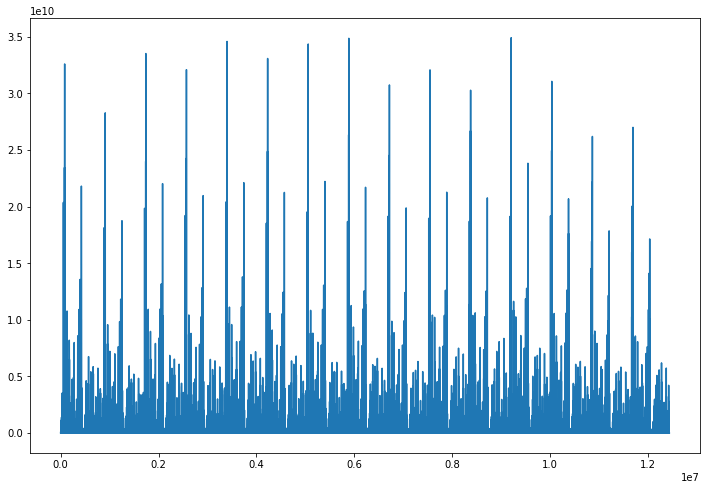

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(df_raw['AMT'].dropna())

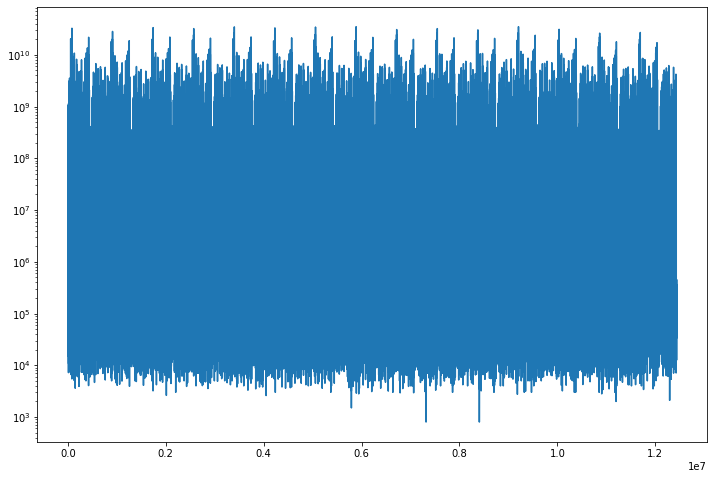

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(df_raw['AMT'].dropna())
plt.yscale('log')

In [12]:
# 원래 최대 최소 분포 파악
df_raw['AMT'].max(), df_raw['AMT'].min()

(34925518737.0, 800.0)

### 스케일 조정하며 AMT 파악
- log1p : log(1 + x), the inverse of expm1.
- 중간값 잘 가는지 분포 파악.

In [13]:
def plot_log1p_scaled_AMT(data, n=3):
    df = data
    for i in range(n+1):
        print(f"결측치 대체: {10**i}")
        df_temp = df.fillna(value=10**i)
        df_temp['AMT'] = np.log1p(df_temp['AMT']) # log 적용
        display(df_temp.head()) # 잘 채워졌는지 확인용
        # plt.figure()
        print(f" ======= <scale 후> ======= 최댓값: {df_temp['AMT'].max()}, 최솟값: {df_temp['AMT'].min()}")
        # plt.plot(df_temp['AMT']) # 확인이 잘 안 되는듯?
        plt.boxplot(df_temp['AMT'], vert=False)
        plt.show()
        sns.kdeplot(df_temp['AMT'])
        plt.show()
        print()

결측치 대체: 1


,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT
0,201901,강원,건강보조식품 소매업,강원,20s,1,1,12.648194
1,201901,강원,건강보조식품 소매업,강원,20s,1,2,0.693147
2,201901,강원,건강보조식품 소매업,강원,20s,1,3,0.693147
3,201901,강원,건강보조식품 소매업,강원,20s,1,4,0.693147
4,201901,강원,건강보조식품 소매업,강원,20s,1,5,0.693147


 ======= <scale 후> ======= 최댓값: 24.276483594892518, 최솟값: 0.6931471805599453


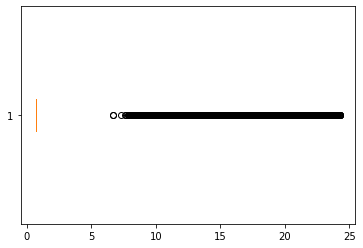

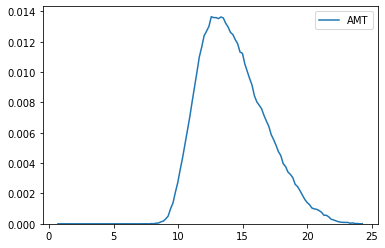


결측치 대체: 10


,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT
0,201901,강원,건강보조식품 소매업,강원,20s,1,1,12.648194
1,201901,강원,건강보조식품 소매업,강원,20s,1,2,2.397895
2,201901,강원,건강보조식품 소매업,강원,20s,1,3,2.397895
3,201901,강원,건강보조식품 소매업,강원,20s,1,4,2.397895
4,201901,강원,건강보조식품 소매업,강원,20s,1,5,2.397895


 ======= <scale 후> ======= 최댓값: 24.276483594892518, 최솟값: 2.3978952727983707


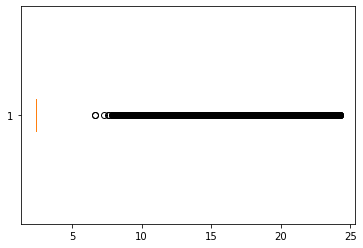

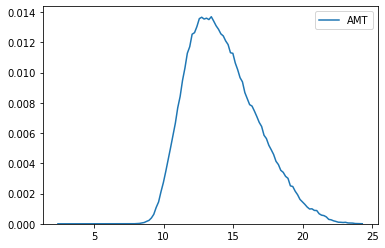


결측치 대체: 100


,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT
0,201901,강원,건강보조식품 소매업,강원,20s,1,1,12.648194
1,201901,강원,건강보조식품 소매업,강원,20s,1,2,4.615121
2,201901,강원,건강보조식품 소매업,강원,20s,1,3,4.615121
3,201901,강원,건강보조식품 소매업,강원,20s,1,4,4.615121
4,201901,강원,건강보조식품 소매업,강원,20s,1,5,4.615121


 ======= <scale 후> ======= 최댓값: 24.276483594892518, 최솟값: 4.61512051684126


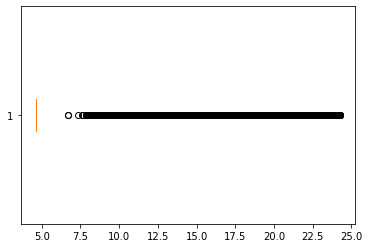

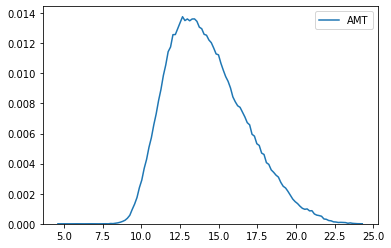


결측치 대체: 1000


,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT
0,201901,강원,건강보조식품 소매업,강원,20s,1,1,12.648194
1,201901,강원,건강보조식품 소매업,강원,20s,1,2,6.908755
2,201901,강원,건강보조식품 소매업,강원,20s,1,3,6.908755
3,201901,강원,건강보조식품 소매업,강원,20s,1,4,6.908755
4,201901,강원,건강보조식품 소매업,강원,20s,1,5,6.908755


 ======= <scale 후> ======= 최댓값: 24.276483594892518, 최솟값: 6.68586094706836


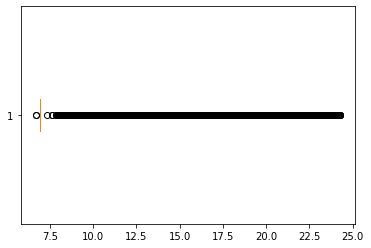

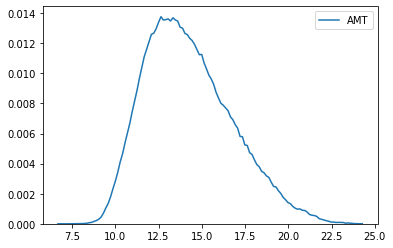


결측치 대체: 10000


,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT
0,201901,강원,건강보조식품 소매업,강원,20s,1,1,12.648194
1,201901,강원,건강보조식품 소매업,강원,20s,1,2,9.210440
2,201901,강원,건강보조식품 소매업,강원,20s,1,3,9.210440
3,201901,강원,건강보조식품 소매업,강원,20s,1,4,9.210440
4,201901,강원,건강보조식품 소매업,강원,20s,1,5,9.210440


 ======= <scale 후> ======= 최댓값: 24.276483594892518, 최솟값: 6.68586094706836


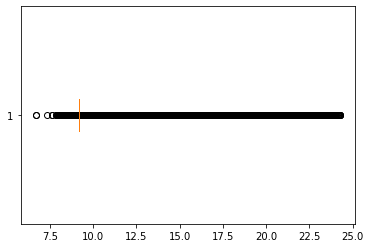

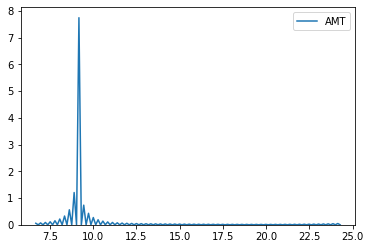


결측치 대체: 100000


,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT
0,201901,강원,건강보조식품 소매업,강원,20s,1,1,12.648194
1,201901,강원,건강보조식품 소매업,강원,20s,1,2,11.512935
2,201901,강원,건강보조식품 소매업,강원,20s,1,3,11.512935
3,201901,강원,건강보조식품 소매업,강원,20s,1,4,11.512935
4,201901,강원,건강보조식품 소매업,강원,20s,1,5,11.512935


 ======= <scale 후> ======= 최댓값: 24.276483594892518, 최솟값: 6.68586094706836


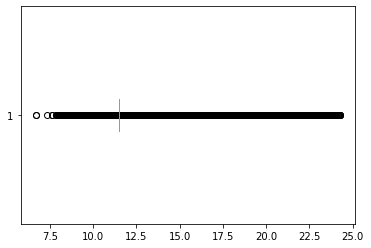

In [ ]:
plot_log1p_scaled_AMT(df_raw, n=6)

### 결측치: 10으로 채우기 우선

In [4]:
# 결측치 대체
df = df_raw.fillna(10)
df.isnull().sum()

REG_YYMM        0
CARD_SIDO_NM    0
STD_CLSS_NM     0
HOM_SIDO_NM     0
AGE             0
SEX_CTGO_CD     0
FLC             0
AMT             0
dtype: int64

In [5]:
df.to_csv(f"{data_path}/jeju-data-merged_01_fillna10.csv", index=False, encoding='utf-8-sig')

# _4_. 시계열 단위로 잘라서 데이터셋 만들기

- `201901` ~ `202003` 까지 각각 829430개 있다.
- `AMT` 열만 잘라서 시계열 배열로 만들자.

In [3]:
df = pd.read_csv(f"{data_path}/jeju-data-merged_01_fillna10.csv")

### 테스트

In [5]:
df.groupby('REG_YYMM').count()

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT
REG_YYMM,,,,,,,
201901,829430,829430,829430,829430,829430,829430,829430
201902,829430,829430,829430,829430,829430,829430,829430
201903,829430,829430,829430,829430,829430,829430,829430
201904,829430,829430,829430,829430,829430,829430,829430
201905,829430,829430,829430,829430,829430,829430,829430
201906,829430,829430,829430,829430,829430,829430,829430
201907,829430,829430,829430,829430,829430,829430,829430
201908,829430,829430,829430,829430,829430,829430,829430
201909,829430,829430,829430,829430,829430,829430,829430


In [19]:
for i in range(829430):
    for j in range(15):
        print(df.values[829430*j+i, :])
    if i == 3:
        break

[201901 '강원' '건강보조식품 소매업' '강원' '20s' 1 1 311200.0]
[201902 '강원' '건강보조식품 소매업' '강원' '20s' 1 1 605000.0]
[201903 '강원' '건강보조식품 소매업' '강원' '20s' 1 1 10.0]
[201904 '강원' '건강보조식품 소매업' '강원' '20s' 1 1 10.0]
[201905 '강원' '건강보조식품 소매업' '강원' '20s' 1 1 10.0]
[201906 '강원' '건강보조식품 소매업' '강원' '20s' 1 1 139000.0]
[201907 '강원' '건강보조식품 소매업' '강원' '20s' 1 1 10.0]
[201908 '강원' '건강보조식품 소매업' '강원' '20s' 1 1 27500.0]
[201909 '강원' '건강보조식품 소매업' '강원' '20s' 1 1 395500.0]
[201910 '강원' '건강보조식품 소매업' '강원' '20s' 1 1 10.0]
[201911 '강원' '건강보조식품 소매업' '강원' '20s' 1 1 843100.0]
[201912 '강원' '건강보조식품 소매업' '강원' '20s' 1 1 10.0]
[202001 '강원' '건강보조식품 소매업' '강원' '20s' 1 1 168500.0]
[202002 '강원' '건강보조식품 소매업' '강원' '20s' 1 1 10.0]
[202003 '강원' '건강보조식품 소매업' '강원' '20s' 1 1 427510.0]
[201901 '강원' '건강보조식품 소매업' '강원' '20s' 1 2 10.0]
[201902 '강원' '건강보조식품 소매업' '강원' '20s' 1 2 10.0]
[201903 '강원' '건강보조식품 소매업' '강원' '20s' 1 2 10.0]
[201904 '강원' '건강보조식품 소매업' '강원' '20s' 1 2 10.0]
[201905 '강원' '건강보조식품 소매업' '강원' '20s' 1 2 10.0]
[201906 '강원' '건강보조식품 소매업' '강원

### AMT만 자르기

In [7]:
amt = np.array(df[['AMT']].values, dtype=np.float32)

In [8]:
amt.dtype

dtype('float32')

In [9]:
# 메모리 관리
del df

In [11]:
amt.shape

(12441450, 1)

### 각각의 829430개 분류에 대한 15기간 시계열 데이터

In [12]:
data = []

for i in range(829430):
    temp = []
    for j in range(15):
        temp.append(amt[829430*j+i, :])
    data.append(temp)

In [22]:
data = np.array(data)
data = data.reshape(data.shape[0], data.shape[1])
data.shape # 15개의 기간이 829430개 있음.

(829430, 15)

# _5_. LSTM 모델링

* data log1p로 만들기

In [25]:
# log 변환
print(data)
data = np.log1p(data)
print(data)

[[3.1120e+05 6.0500e+05 1.0000e+01 ... 1.6850e+05 1.0000e+01 4.2751e+05]
 [1.0000e+01 1.0000e+01 1.0000e+01 ... 1.0000e+01 1.0000e+01 1.0000e+01]
 [1.0000e+01 1.0000e+01 1.0000e+01 ... 1.0000e+01 1.0000e+01 1.0000e+01]
 ...
 [1.0000e+01 1.0000e+01 1.0000e+01 ... 1.0000e+01 1.0000e+01 1.0000e+01]
 [1.0000e+01 1.0000e+01 1.0000e+01 ... 1.0000e+01 1.0000e+01 1.0000e+01]
 [1.0000e+01 1.0000e+01 1.0000e+01 ... 1.0000e+01 1.0000e+01 1.0000e+01]]
[[12.648194  13.312985   2.3978953 ... 12.034697   2.3978953 12.965735 ]
 [ 2.3978953  2.3978953  2.3978953 ...  2.3978953  2.3978953  2.3978953]
 [ 2.3978953  2.3978953  2.3978953 ...  2.3978953  2.3978953  2.3978953]
 ...
 [ 2.3978953  2.3978953  2.3978953 ...  2.3978953  2.3978953  2.3978953]
 [ 2.3978953  2.3978953  2.3978953 ...  2.3978953  2.3978953  2.3978953]
 [ 2.3978953  2.3978953  2.3978953 ...  2.3978953  2.3978953  2.3978953]]


In [67]:
tf.compat.v1.disable_eager_execution()

# 파라미터 설정
n_step = 5
n_features = 1
# n_futures = 1
n_hidden = 128
n_output = n_features
EPOCHS = 300
BATCH = 32

In [68]:
# LSTM 데이터 생성
def create_lstm_data(X_data, step):
    m = np.arange(len(X_data)-step)
    x, y = [], []
    for i in m:
        a = X_data[i:i+step]
        b = X_data[i+step]
        x.append(a)
        y.append(b)
    X = np.reshape(np.array(x), (len(m), step, 1))
    Y = np.reshape(np.array(y), (len(m), 1))
    return X, Y

In [69]:
# 모델링
def train_lstm(X, y):
    K.clear_session() # 그래프 초기화

    X_input = Input(batch_shape = (None, n_step, n_features))
    X_lstm = LSTM(n_hidden)(X_input)
    X_output = Dense(n_output)(X_lstm)

    model = Model(X_input, X_output)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))
    print(model.summary())
    
    # es = ear
    hist = model.fit(X, y,
                     epochs=EPOCHS,
                     batch_size=BATCH)
    
    return model

In [70]:
def predict_lstm(x, lstm_model):
    model = lstm_model
    y_pred = model.predict(x)
    return y_pred

In [ ]:
estimates = []

for i in range(len(data)):
    print(f"========= {i}번째 시계열 데이터: {data[i]} =========")

    # 각 데이터에 대해 LSTM 입력 데이터 형식으로 변환
    X_train, y_train = create_lstm_data(data[i], n_step)
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")

    # LSTM 모델 학습
    model = train_lstm(X_train, y_train) 

    # 1기간만 예측
    X_pred = data[i][-n_step:].reshape(1, n_step, 1) # 예측해야 할 데이터
    y_pred = predict_lstm(X_pred, model)[0][0]
    estimates.append(temp)
    print()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
10/10 [==============================] - 0s 240us/sample - loss: 3.1934e-05
Epoch 102/300
10/10 [==============================] - 0s 249us/sample - loss: 2.4792e-05
Epoch 103/300
10/10 [==============================] - 0s 182us/sample - loss: 1.2547e-05
Epoch 104/300
10/10 [==============================] - 0s 199us/sample - loss: 2.7299e-06
Epoch 105/300
10/10 [==============================] - 0s 225us/sample - loss: 1.1078e-07
Epoch 106/300
10/10 [==============================] - 0s 206us/sample - loss: 4.2916e-06
Epoch 107/300
10/10 [==============================] - 0s 281us/sample - loss: 1.0844e-05
Epoch 108/300
10/10 [==============================] - 0s 214us/sample - loss: 1.4744e-05
Epoch 109/300
10/10 [==============================] - 0s 170us/sample - loss: 1.3548e-05
Epoch 110/300
10/10 [==============================] - 0s 180us/sample - loss: 8.4523e-06
Epoch 111/300
10/10 [==============================] - 0s 208us/sample - loss:

In [65]:
estimates

[[1.8412275], [2.3978953]]

In [ ]:
len(estimates)

# _6_. 템플릿에 4월 데이터 붙이고 submission 양식에 맞게 변환